# [Chapter 13].금융 보이스피싱 실시간 탐지 (Fraud Detection)
> **목차(Context)**

* Data Spec Check
* 문제해결 프로세스 정의
* Data Info Check
* Data Readiness Check
* Feature Engineering
* Modeling
* Model evaluation and Summary

## **문제상황 설명**

```
1. 금융거래 이상치 탐지 진행
2. 여러 개의 변수(X's) 중 한개의 변수에서 이상 거래가 발생했을 때 탐지함
3. 변수 마다 Model을 만드는게 아닌 하나의 Model을 활용하여 수행함
```
```
■ Check Point
   → 한개의 변수에만 적용하는 것이 아닌 여러 개의 변수에 적용함
   → 이상치를 Rule로 정하는 것이 아니라 Model이 알아서 정해줌
   → 현업에서는 이상치에 대한 Label이 존재하지 않음
      → 이상치라는 것은 다양한 형태가 있기 때문에 특정적으로 정의하기 어려움
      → Chap12에서 효율이라는 것은 고/저를 판단할 수 있었지만 이러한 문제상황에서는 어려움
   → 본 실습시간에는 Label이 있지만 Label 없이 진행하겠음
```
```
■ 기대효과
   → 실시간 이상치 탐지를 활용하여 피해 상황을 막을 수 있음
   → 금융사 브랜드 이미지 제고 가능
   → 금융에서는 안전이 제일 우선이기 때문에 선진적인 알고리즘을 활용하여 안전 마케팅 수행 가능
```
```
■ 성과측정
   → 알고리즘이 탐지한 이상 거래 만큼 피해액 계산
   → 년 단위 피해액 합산 후 브랜드 이미지 마케팅 활용 가능
   → 새로운 시니어 고객 유치 및 MZ 세대 안전 마케팅 수행
```

```
■ 전체적인 Process
   → 실시간 DB를 활용하여 데이터 수집
      : 실시간성이 없으면 방지가 불가능하기 때문에 실시간 DB 구축 필수
        카프카, 인플럭스DB 등
   → 미리 학습시켜 놓은 Model에 데이터 Input 후 이상 거래 판단
   → 이상 거래 판단 시 고객에게 실시간 전달
   → 사후 Care 필요
```

## **Data info Check**

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape,Input

In [4]:
# Data Load
data = pd.read_excel("Data/data.xlsx")
print("Data Shape : {}".format(data.shape))

Data Shape : (687, 6)


In [5]:
data.describe()

,Time,Y1,Y2,Y3,Y4,Label
count,687.000000,687.000000,687.000000,687.000000,687.000000,687.000000
mean,344.000000,5.035127,50.997501,25.396162,50.535352,0.016012
std,198.464103,0.130613,1.413051,0.602280,1.141266,0.125611
min,1.000000,4.692480,47.683200,24.475200,47.961600,0.000000
25%,172.500000,4.976500,50.395000,25.130000,50.005000,0.000000
50%,344.000000,5.025000,50.870000,25.345000,50.480000,0.000000
75%,515.500000,5.077500,51.365000,25.567500,50.930000,0.000000
max,687.000000,6.205200,63.396000,30.888000,61.368000,1.000000


In [6]:
data[data['Label'] == 1]

,Time,Y1,Y2,Y3,Y4,Label
11,12,6.15480,60.5520,24.4752,61.0440,1
67,68,4.69248,62.2320,30.4980,47.9616,1
136,137,5.99520,62.0520,24.4896,48.2112,1
315,316,5.93520,47.6832,30.2280,59.3160,1
361,362,4.80288,61.1280,30.1200,48.2784,1
476,477,4.86240,61.3560,30.4260,61.2840,1
498,499,6.07800,63.3960,24.4848,61.3680,1
525,526,6.05880,61.5120,29.7660,48.4224,1
612,613,5.97480,61.5720,24.5184,59.1840,1
666,667,6.20520,48.7200,30.8880,48.6912,1


In [8]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687 entries, 0 to 686
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    687 non-null    int64  
 1   Y1      687 non-null    float64
 2   Y2      687 non-null    float64
 3   Y3      687 non-null    float64
 4   Y4      687 non-null    float64
 5   Label   687 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 32.3 KB


In [9]:
data.describe()

,Time,Y1,Y2,Y3,Y4,Label
count,687.000000,687.000000,687.000000,687.000000,687.000000,687.000000
mean,344.000000,5.035127,50.997501,25.396162,50.535352,0.016012
std,198.464103,0.130613,1.413051,0.602280,1.141266,0.125611
min,1.000000,4.692480,47.683200,24.475200,47.961600,0.000000
25%,172.500000,4.976500,50.395000,25.130000,50.005000,0.000000
50%,344.000000,5.025000,50.870000,25.345000,50.480000,0.000000
75%,515.500000,5.077500,51.365000,25.567500,50.930000,0.000000
max,687.000000,6.205200,63.396000,30.888000,61.368000,1.000000


## **Data Readiness Check**

In [10]:
# Data Missing
col = []
missing = []
for name in data.columns:
    
    # Missing
    missper = data[name].isnull().sum() / data.shape[0]
    missing.append(round(missper, 4))

In [11]:
data.columns

Index(['Time', 'Y1', 'Y2', 'Y3', 'Y4', 'Label'], dtype='object')

In [12]:
missing

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [13]:
# Unique Checking
col = []
level = [] 
for name in data.columns:
    
    # Leveling
    lel = data[name].dropna()
    level.append(len(list(set(lel))))

    # Columns
    col.append(name)

In [14]:
# Data Missing에 대해 DataFrame을 만들어줌
summary = pd.concat([pd.DataFrame(col, columns=['name']), 
                     pd.DataFrame(missing, columns=['Missing Percentage']), 
                     pd.DataFrame(level, columns=['Unique'])], axis=1)

In [15]:
summary

,name,Missing Percentage,Unique
0,Time,0.0,687
1,Y1,0.0,273
2,Y2,0.0,259
3,Y3,0.0,266
4,Y4,0.0,250
5,Label,0.0,2


In [16]:
# Data Cutting
drop_col = summary['name'][(summary['Unique'] <= 1) | (summary['Missing Percentage'] >= 0.8)]
data.drop(columns=drop_col, inplace=True)
print(">>>> Data Shape : {}".format(data.shape))

>>>> Data Shape : (687, 6)


In [17]:
len(drop_col)

0

In [18]:
np.percentile(data['Y1'], 20)

4.9652

In [19]:
np.percentile(data['Y1'], 80)

5.087

In [20]:
data['Time'][data['Label'] == 1]

11      12
67      68
136    137
315    316
361    362
476    477
498    499
525    526
612    613
666    667
685    686
Name: Time, dtype: int64

In [21]:
data['Y1'][data['Label'] == 1]

11     6.15480
67     4.69248
136    5.99520
315    5.93520
361    4.80288
476    4.86240
498    6.07800
525    6.05880
612    5.97480
666    6.20520
685    5.94480
Name: Y1, dtype: float64

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


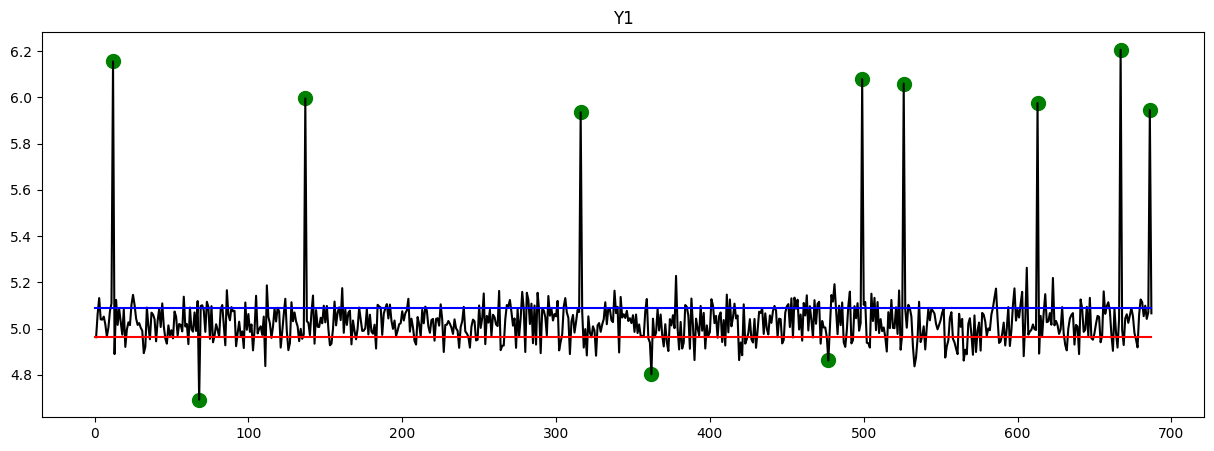

In [22]:
# Y1 Plot
plt.figure(figsize=(15,5))
plt.plot(data['Time'], data['Y1'], c='black')
plt.plot([0, data.shape[0]], [np.percentile(data['Y1'], 20), np.percentile(data['Y1'], 20)],c='red')
plt.plot([0, data.shape[0]], [np.percentile(data['Y1'], 80), np.percentile(data['Y1'], 80)],c='blue')
plt.scatter(data['Time'][data['Label'] == 1], data['Y1'][data['Label'] == 1], s=100, c='green')
plt.title("Y1")
plt.show()

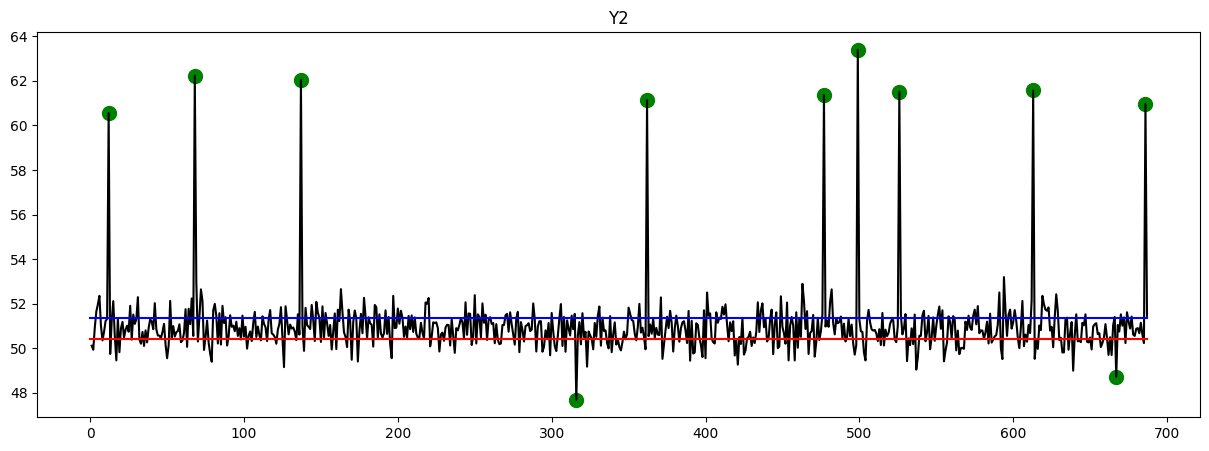

In [23]:
# Y2 Plot
plt.figure(figsize=(15,5))
plt.plot(data['Time'], data['Y2'], c='black')
plt.plot([0, data.shape[0]], [np.percentile(data['Y2'], 25), np.percentile(data['Y2'], 25)],c='red')
plt.plot([0, data.shape[0]], [np.percentile(data['Y2'], 75), np.percentile(data['Y2'], 75)],c='blue')
plt.scatter(data['Time'][data['Label'] == 1], data['Y2'][data['Label'] == 1], s=100, c='green')
plt.title("Y2")
plt.show()

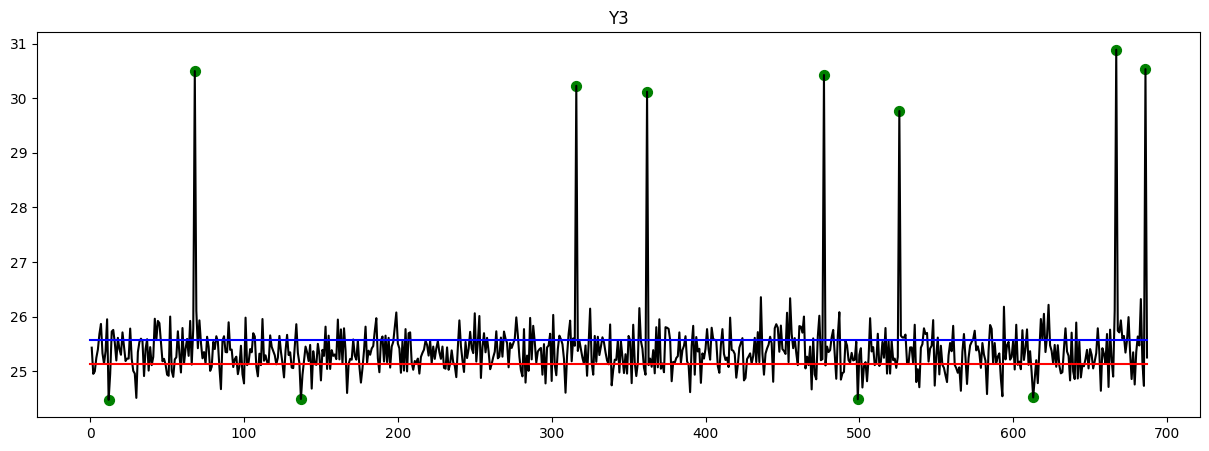

In [24]:
# Y3 Plot
plt.figure(figsize=(15,5))
plt.plot(data['Time'], data['Y3'], c='black')
plt.plot([0, data.shape[0]], [np.percentile(data['Y3'], 25), np.percentile(data['Y3'], 25)],c='red')
plt.plot([0, data.shape[0]], [np.percentile(data['Y3'], 75), np.percentile(data['Y3'], 75)],c='blue')
plt.scatter(data['Time'][data['Label'] == 1], data['Y3'][data['Label'] == 1], s=50, c='green')
plt.title("Y3")
plt.show()

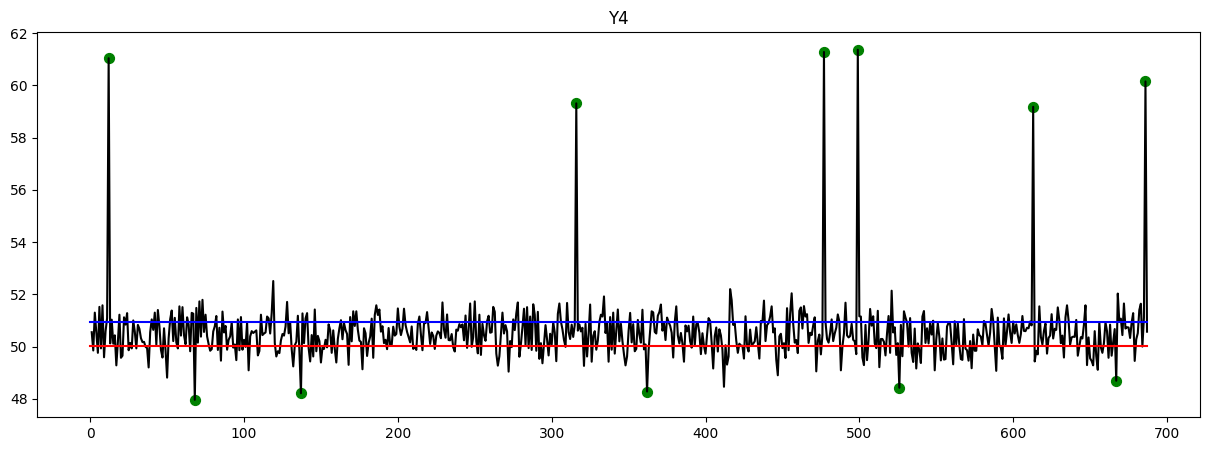

In [25]:
# Y4 Plot
plt.figure(figsize=(15,5))
plt.plot(data['Time'], data['Y4'], c='black')
plt.plot([0, data.shape[0]], [np.percentile(data['Y4'], 25), np.percentile(data['Y4'], 25)],c='red')
plt.plot([0, data.shape[0]], [np.percentile(data['Y4'], 75), np.percentile(data['Y4'], 75)],c='blue')
plt.scatter(data['Time'][data['Label'] == 1], data['Y4'][data['Label'] == 1], s=50, c='green')
plt.title("Y4")
plt.show()

■ 이상치 정의
   - Y1, Y2, Y3, Y4 하나라도 이상치일 경우 이상치로 판단함
   - 현재 Y1, Y2, Y3, Y4 모두 Scale이 다름

## **Feature Engineering**
 - Autoencoder를 활용하여 1개의 변수로 Feature Extraction 수행 가능
   - 이론 상 이상치 탐지를 할때 이상치를 제거하고 정상데이터만 가지고 학습하지만 현업과 동일한 상황을 연출하기 위해 이상치도 같이 학습함
   - 학습시 이상치까지 학습하지 못하도록 (Overfitting) 수행함

In [26]:
# Train Valid Split
# 데이터가 작기때문에 데이터를 그냥 나누어줌
# 현실에서는 Index Play 필수
# Train Valid split 시 시간에 따른 스플릿 필요
train_idx = list(range(int(data.shape[0]*0.7)))
valid_idx = list(range(int(data.shape[0]*0.7), data.shape[0]))

In [27]:
data

,Time,Y1,Y2,Y3,Y4,Label
0,1,4.9630,50.11,25.430,50.550,0
1,2,5.0630,49.93,24.950,49.850,0
2,3,5.1320,50.93,24.995,51.300,0
3,4,5.0400,51.65,25.245,50.520,0
4,5,5.0390,51.97,25.395,49.760,0
...,...,...,...,...,...,...
682,683,5.0990,51.14,26.320,51.640,0
683,684,5.0420,50.61,25.170,50.000,0
684,685,5.0710,50.23,24.730,51.110,0
685,686,5.9448,60.96,30.534,60.156,1


In [28]:
data['Label'].iloc[train_idx] == 1

0      False
1      False
2      False
3      False
4      False
       ...  
475    False
476     True
477    False
478    False
479    False
Name: Label, Length: 480, dtype: bool

In [29]:
x_train = data.iloc[train_idx,1:-1]
x_valid = data.iloc[valid_idx,1:-1]

In [30]:
x_train

,Y1,Y2,Y3,Y4
0,4.9630,50.110,25.430,50.550
1,5.0630,49.930,24.950,49.850
2,5.1320,50.930,24.995,51.300
3,5.0400,51.650,25.245,50.520
4,5.0390,51.970,25.395,49.760
...,...,...,...,...
475,4.9640,51.520,25.220,50.440
476,4.8624,61.356,30.426,61.284
477,5.0030,50.970,25.105,50.940
478,5.1450,51.250,25.450,50.290


In [31]:
x_valid

,Y1,Y2,Y3,Y4
480,5.1920,52.08,25.385,50.510
481,5.0850,52.64,25.620,51.040
482,4.9760,51.12,25.755,50.210
483,5.0990,50.62,25.310,50.500
484,5.0150,51.31,24.860,50.720
...,...,...,...,...
682,5.0990,51.14,26.320,51.640
683,5.0420,50.61,25.170,50.000
684,5.0710,50.23,24.730,51.110
685,5.9448,60.96,30.534,60.156


In [32]:
# This is the dimension of the latent space (encoding space)
latent_dim = 1

# input size 4개
data_shape = x_train.shape[1]

encoder = Sequential([
    Input(shape=data_shape),
    Dense(2, activation='relu'),
    Dense(latent_dim, name='encoder_output')])

decoder = Sequential([
    Dense(2, activation='relu', input_shape=(latent_dim,)),
    Dense(data_shape)])

In [33]:
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))

In [34]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 2)                 10        
                                                                 
 encoder_output (Dense)      (None, 1)                 3         
                                                                 
 sequential_1 (Sequential)   (None, 4)                 16        
                                                                 
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


In [35]:
autoencoder.compile(loss='mean_squared_error', optimizer='adam')
autoencoder.fit(x_train, x_train, epochs=100, verbose=1)

Epoch 1/100
15/15 [==============================] - 1s 2ms/step - loss: 2180.9177
Epoch 2/100
15/15 [==============================] - 0s 2ms/step - loss: 2067.4619
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 1971.3894
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 1890.9045
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 1823.2870
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 1766.3088
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 1717.8912
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 1676.4808
Epoch 9/100
15/15 [==============================] - 0s 2ms/step - loss: 1640.8429
Epoch 10/100
15/15 [==============================] - 0s 2ms/step - loss: 1609.9945
Epoch 11/100
15/15 [==============================] - 0s 2ms/step - loss: 1583.1117
Epoch 12/100
15/15 [==============================] - 0s 2ms/step - loss: 1559.5372
E

In [36]:
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder_output').output)

In [37]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 2)                 10        
                                                                 
 encoder_output (Dense)      (None, 1)                 3         
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [38]:
dim_1 = encoder_model.predict(data.iloc[:,1:-1])

22/22 [==============================] - 0s 1ms/step


In [39]:
dim_1

array([[-56.082005],
       [-55.4881  ],
       [-56.89354 ],
       [-56.807213],
       [-56.485516],
       [-57.803913],
       [-56.116978],
       [-56.86123 ],
       [-55.759056],
       [-56.617672],
       [-56.975586],
       [-67.53744 ],
       [-55.646893],
       [-56.88639 ],
       [-56.79658 ],
       [-56.171978],
       [-54.89806 ],
       [-56.47291 ],
       [-56.30618 ],
       [-55.869343],
       [-56.037663],
       [-56.605183],
       [-56.60618 ],
       [-56.9378  ],
       [-55.870647],
       [-56.667797],
       [-55.7809  ],
       [-57.05186 ],
       [-56.558228],
       [-56.258846],
       [-57.35616 ],
       [-56.342   ],
       [-56.002586],
       [-56.094444],
       [-55.81077 ],
       [-56.07825 ],
       [-55.718964],
       [-55.57199 ],
       [-56.6453  ],
       [-56.95497 ],
       [-56.48012 ],
       [-57.482937],
       [-56.126713],
       [-56.79731 ],
       [-56.441216],
       [-55.823414],
       [-55.786125],
       [-56.6

In [40]:
data['dim_1'] = - (dim_1)

In [41]:
data['dim_1']

0      56.082005
1      55.488098
2      56.893539
3      56.807213
4      56.485516
         ...    
682    57.250992
683    55.943016
684    56.441338
685    67.354179
686    56.725159
Name: dim_1, Length: 687, dtype: float32

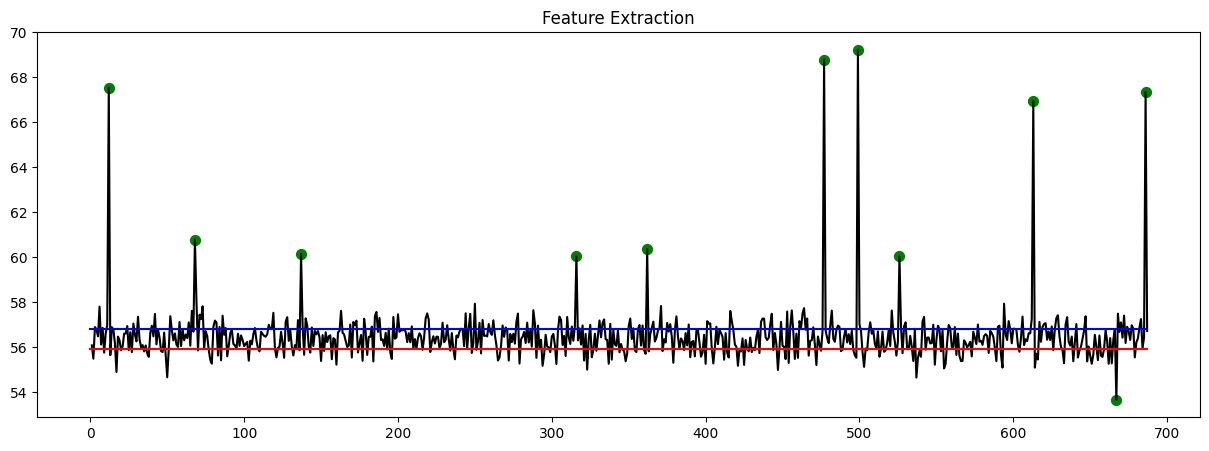

In [42]:
# dim_1 Plotting
plt.figure(figsize=(15,5))
plt.plot(data['Time'], data['dim_1'], c='black')
plt.plot([0, data.shape[0]], [np.percentile(data['dim_1'], 25), np.percentile(data['dim_1'], 25)],c='red')
plt.plot([0, data.shape[0]], [np.percentile(data['dim_1'], 75), np.percentile(data['dim_1'], 75)],c='blue')
plt.scatter(data['Time'][data['Label'] == 1], data['dim_1'][data['Label'] == 1], s=50, c='green')
plt.title("Feature Extraction")
plt.show()

## **Modeling**
  - LOF 활용 이상치 탐시 수행

In [43]:
data

,Time,Y1,Y2,Y3,Y4,Label,dim_1
0,1,4.9630,50.11,25.430,50.550,0,56.082005
1,2,5.0630,49.93,24.950,49.850,0,55.488098
2,3,5.1320,50.93,24.995,51.300,0,56.893539
3,4,5.0400,51.65,25.245,50.520,0,56.807213
4,5,5.0390,51.97,25.395,49.760,0,56.485516
...,...,...,...,...,...,...,...
682,683,5.0990,51.14,26.320,51.640,0,57.250992
683,684,5.0420,50.61,25.170,50.000,0,55.943016
684,685,5.0710,50.23,24.730,51.110,0,56.441338
685,686,5.9448,60.96,30.534,60.156,1,67.354179


In [44]:
# LOF Setup
LOF = LocalOutlierFactor(n_neighbors=5)
y_pred = LOF.fit_predict(data.iloc[:, 1:-2])

In [45]:
y_pred

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [46]:
y_pred

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [47]:
for i in range(y_pred.shape[0]):
    if y_pred[i] == 1:
        y_pred[i] = 0
    else:
        y_pred[i] = 1

n_errors = (y_pred != data['Label']).sum()
X_scores = LOF.negative_outlier_factor_

In [48]:
data['lof'] = y_pred

In [49]:
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min()) 

In [50]:
data['lof_score']=radius

In [51]:
data

,Time,Y1,Y2,Y3,Y4,Label,dim_1,lof,lof_score
0,1,4.9630,50.11,25.430,50.550,0,56.082005,0,0.006702
1,2,5.0630,49.93,24.950,49.850,0,55.488098,0,0.005950
2,3,5.1320,50.93,24.995,51.300,0,56.893539,0,0.023519
3,4,5.0400,51.65,25.245,50.520,0,56.807213,0,0.008254
4,5,5.0390,51.97,25.395,49.760,0,56.485516,0,0.013839
...,...,...,...,...,...,...,...,...,...
682,683,5.0990,51.14,26.320,51.640,0,57.250992,1,0.043580
683,684,5.0420,50.61,25.170,50.000,0,55.943016,0,0.004379
684,685,5.0710,50.23,24.730,51.110,0,56.441338,0,0.023241
685,686,5.9448,60.96,30.534,60.156,1,67.354179,0,0.007993


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


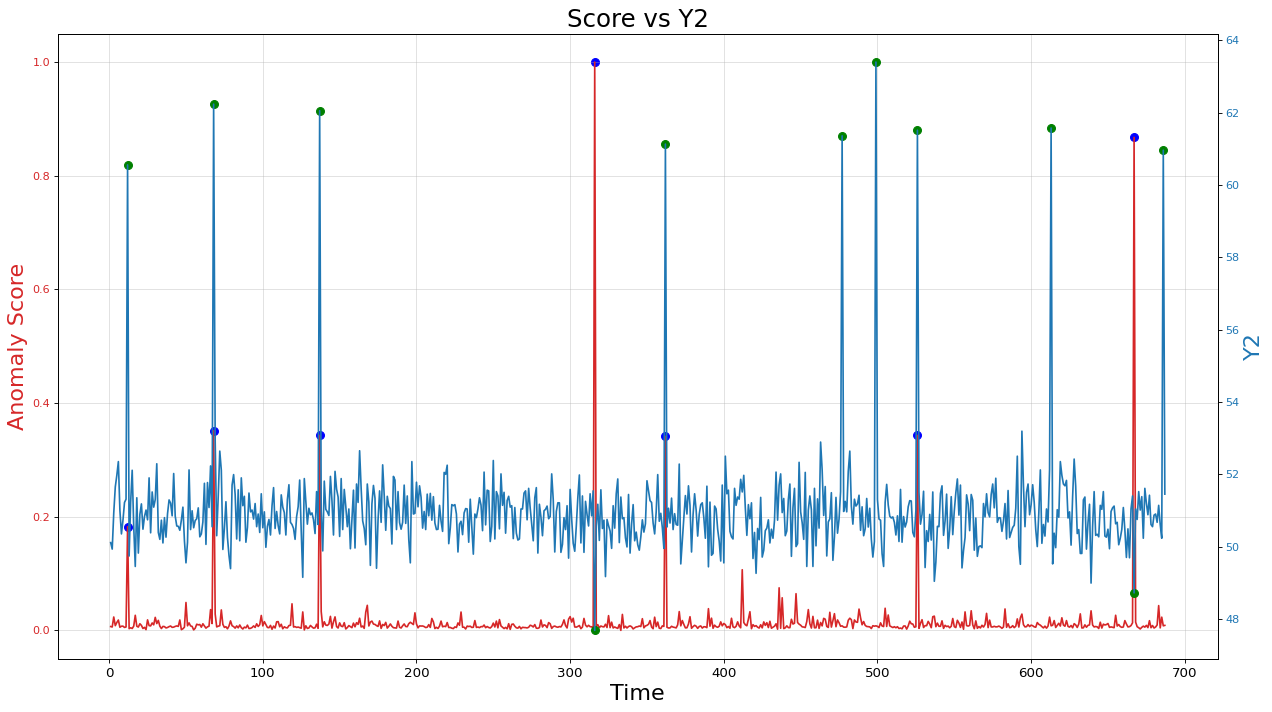

In [52]:
# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 80)
ax1.plot(data['Time'], radius, color='tab:red')
ax1.scatter(data['Time'][data['lof_score'] >= 0.18], data['lof_score'][data['lof_score'] >= 0.18], s=50, c='blue')

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(data['Time'], data['Y2'], color='tab:blue')
ax2.scatter(data['Time'][data['Label'] == 1], data['Y2'][data['Label'] == 1], s=50, c='green')

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Time', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('Anomaly Score', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Y2", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title("Score vs Y2", fontsize=22)
fig.tight_layout()
plt.show()

In [53]:
data

,Time,Y1,Y2,Y3,Y4,Label,dim_1,lof,lof_score
0,1,4.9630,50.11,25.430,50.550,0,56.082005,0,0.006702
1,2,5.0630,49.93,24.950,49.850,0,55.488098,0,0.005950
2,3,5.1320,50.93,24.995,51.300,0,56.893539,0,0.023519
3,4,5.0400,51.65,25.245,50.520,0,56.807213,0,0.008254
4,5,5.0390,51.97,25.395,49.760,0,56.485516,0,0.013839
...,...,...,...,...,...,...,...,...,...
682,683,5.0990,51.14,26.320,51.640,0,57.250992,1,0.043580
683,684,5.0420,50.61,25.170,50.000,0,55.943016,0,0.004379
684,685,5.0710,50.23,24.730,51.110,0,56.441338,0,0.023241
685,686,5.9448,60.96,30.534,60.156,1,67.354179,0,0.007993


In [54]:
# Isolation Forest Setup
IF = IsolationForest(n_estimators = 50, max_samples = 600)
IF.fit(data[['Y1', 'Y2', 'Y3', 'Y4']])
y_pred = IF.predict(data[['Y1', 'Y2', 'Y3', 'Y4']])

for i in range(y_pred.shape[0]):
    if y_pred[i] == 1:
        y_pred[i] = 0
    else:
        y_pred[i] = 1
X_scores = IF.score_samples(data[['Y1', 'Y2', 'Y3', 'Y4']])

In [55]:
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

In [56]:
data['IF'] = y_pred
data['IF_score'] = radius

In [57]:
data

,Time,Y1,Y2,Y3,Y4,Label,dim_1,lof,lof_score,IF,IF_score
0,1,4.9630,50.11,25.430,50.550,0,56.082005,0,0.006702,0,0.067270
1,2,5.0630,49.93,24.950,49.850,0,55.488098,0,0.005950,0,0.088845
2,3,5.1320,50.93,24.995,51.300,0,56.893539,0,0.023519,0,0.139858
3,4,5.0400,51.65,25.245,50.520,0,56.807213,0,0.008254,0,0.021917
4,5,5.0390,51.97,25.395,49.760,0,56.485516,0,0.013839,0,0.109807
...,...,...,...,...,...,...,...,...,...,...,...
682,683,5.0990,51.14,26.320,51.640,0,57.250992,1,0.043580,1,0.355663
683,684,5.0420,50.61,25.170,50.000,0,55.943016,0,0.004379,0,0.017352
684,685,5.0710,50.23,24.730,51.110,0,56.441338,0,0.023241,0,0.263793
685,686,5.9448,60.96,30.534,60.156,1,67.354179,0,0.007993,1,0.926999


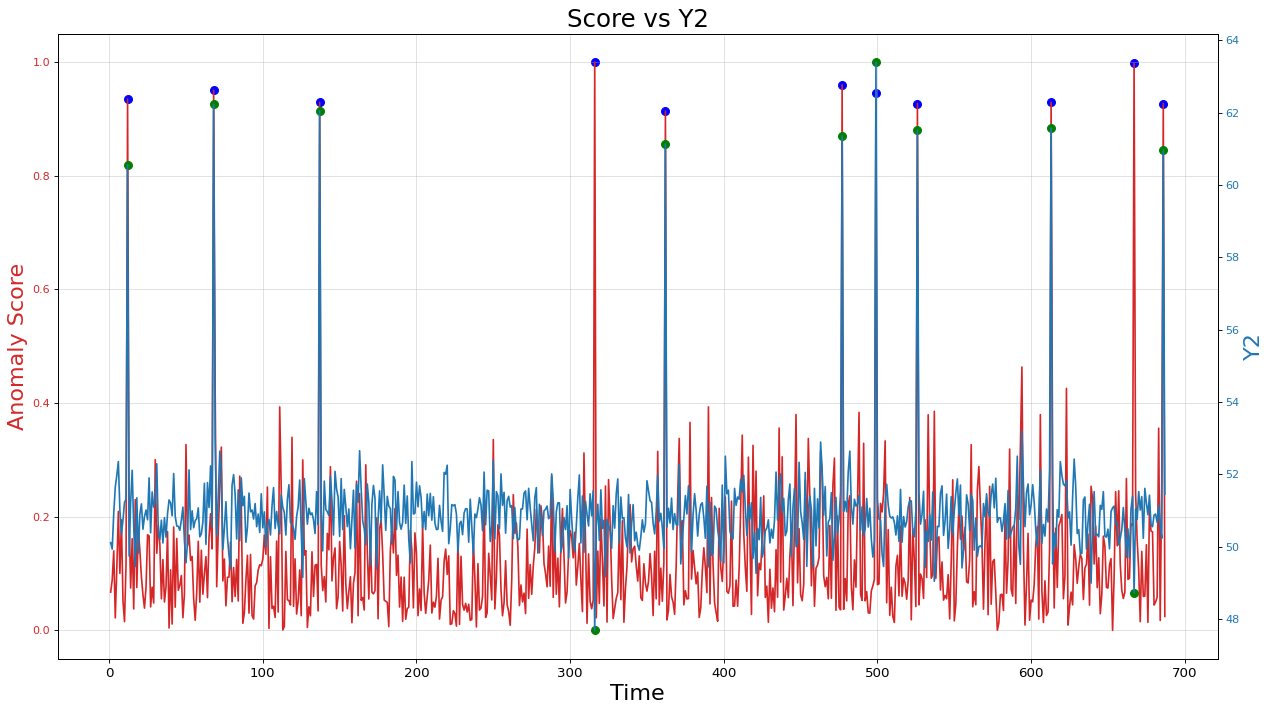

In [58]:
# Plot Line1 (Left Y Axis)
fig, ax1 = plt.subplots(1,1,figsize=(16,9), dpi= 80)
ax1.plot(data['Time'], radius, color='tab:red')
ax1.scatter(data['Time'][data['IF_score'] >= 0.5], data['IF_score'][data['IF_score'] >= 0.5], s=50, c='blue')

# Plot Line2 (Right Y Axis)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(data['Time'], data['Y2'], color='tab:blue')
ax2.scatter(data['Time'][data['Label'] == 1], data['Y2'][data['Label'] == 1], s=50, c='green')

# Decorations
# ax1 (left Y axis)
ax1.set_xlabel('Time', fontsize=20)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('Anomaly Score', color='tab:red', fontsize=20)
ax1.tick_params(axis='y', rotation=0, labelcolor='tab:red' )
ax1.grid(alpha=.4)

# ax2 (right Y axis)
ax2.set_ylabel("Y2", color='tab:blue', fontsize=20)
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.set_title("Score vs Y2", fontsize=22)
fig.tight_layout()
plt.show()

## **Model evaluation and Summary**
  - Autoencoder에서 추출한 1_dim 결과 값과 이상치 탐지 알고리즘과의 비교

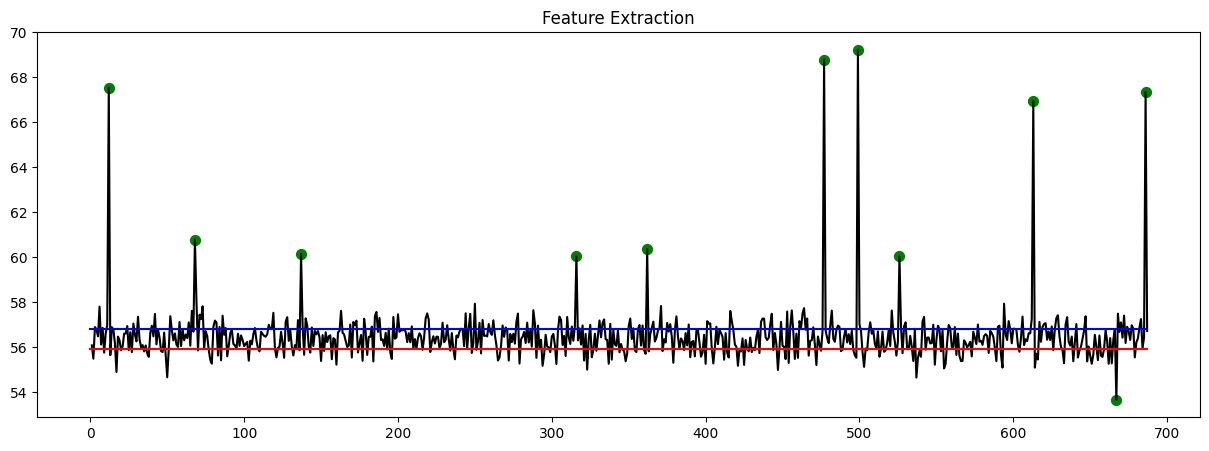

In [59]:
# dim_1 Plotting
plt.figure(figsize=(15,5))
plt.plot(data['Time'], data['dim_1'], c='black')
plt.plot([0, data.shape[0]], [np.percentile(data['dim_1'], 25), np.percentile(data['dim_1'], 25)],c='red')
plt.plot([0, data.shape[0]], [np.percentile(data['dim_1'], 75), np.percentile(data['dim_1'], 75)],c='blue')
plt.scatter(data['Time'][data['Label'] == 1], data['dim_1'][data['Label'] == 1], s=50, c='green')
plt.title("Feature Extraction")
plt.show()

In [60]:
data[['dim_1', 'lof_score', 'IF_score']]

,dim_1,lof_score,IF_score
0,56.082005,0.006702,0.067270
1,55.488098,0.005950,0.088845
2,56.893539,0.023519,0.139858
3,56.807213,0.008254,0.021917
4,56.485516,0.013839,0.109807
...,...,...,...
682,57.250992,0.043580,0.355663
683,55.943016,0.004379,0.017352
684,56.441338,0.023241,0.263793
685,67.354179,0.007993,0.926999


In [61]:
result_scale = data[['dim_1', 'lof_score', 'IF_score']]

In [62]:
result_scale

,dim_1,lof_score,IF_score
0,56.082005,0.006702,0.067270
1,55.488098,0.005950,0.088845
2,56.893539,0.023519,0.139858
3,56.807213,0.008254,0.021917
4,56.485516,0.013839,0.109807
...,...,...,...
682,57.250992,0.043580,0.355663
683,55.943016,0.004379,0.017352
684,56.441338,0.023241,0.263793
685,67.354179,0.007993,0.926999


In [63]:
from sklearn.preprocessing import MinMaxScaler
# Scaling
scaler = MinMaxScaler().fit(result_scale)
result_scal = scaler.transform(result_scale)
result_scal = pd.DataFrame(result_scal, columns=result_scale.columns)

In [64]:
result_scal.describe()

,dim_1,lof_score,IF_score
count,687.000000,687.000000,687.000000
mean,0.181633,0.014881,0.128710
std,0.077465,0.057038,0.134085
min,0.000000,0.000000,0.000000
25%,0.146299,0.005206,0.051922
50%,0.176914,0.007279,0.094151
75%,0.202449,0.011315,0.164618
max,1.000000,1.000000,1.000000


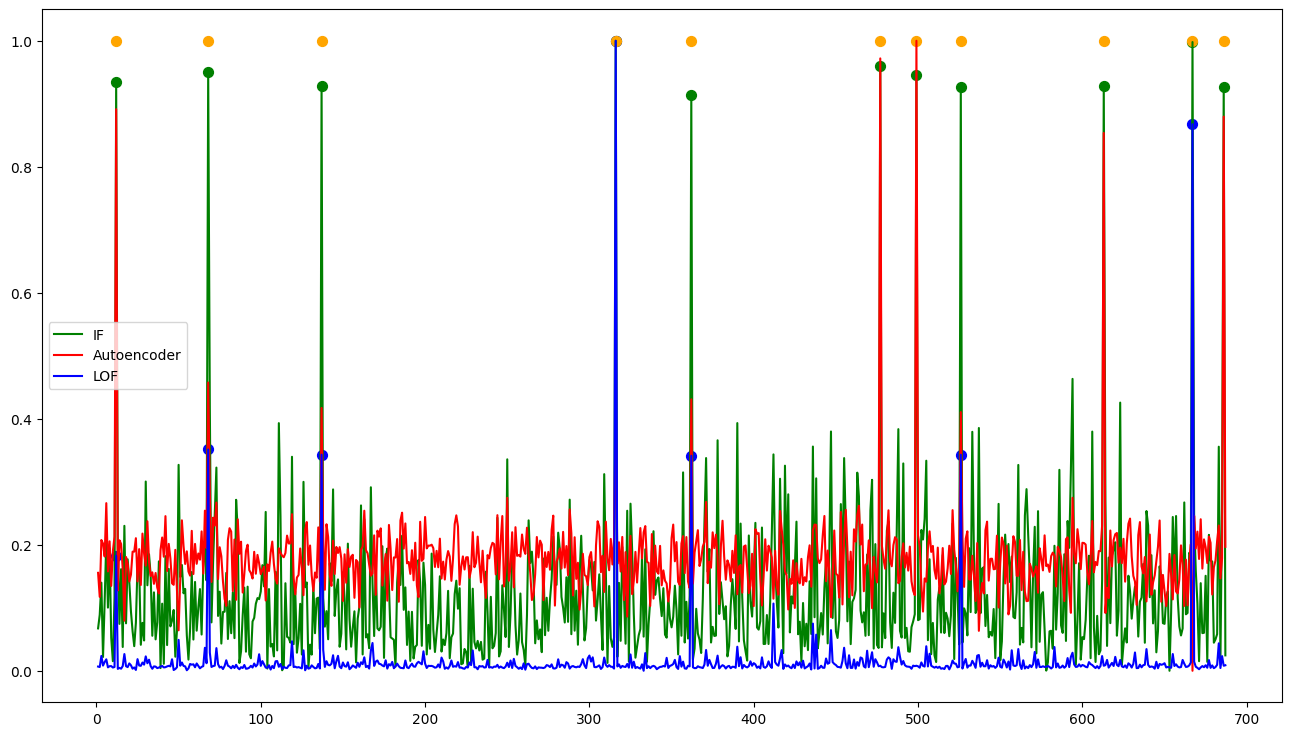

In [65]:
# Result Plotting
plt.figure(figsize=(16,9))
plt.plot(data['Time'], result_scal['IF_score'], c='green', label='IF')
plt.scatter(data['Time'][data['IF_score'] >= 0.5], data['IF_score'][data['IF_score'] >= 0.5], s=50, c='green')
plt.plot(data['Time'], result_scal['dim_1'], c='red', label='Autoencoder')
#plt.scatter(data['Time'][data['dim_1'] >= 0.4], data['dim_1'][data['dim_1'] >= 0.4], s=50, c='red')
plt.plot(data['Time'], result_scal['lof_score'], c='blue', label='LOF')
plt.scatter(data['Time'][data['lof_score'] >= 0.18], data['lof_score'][data['lof_score'] >= 0.18], s=50, c='blue')
plt.scatter(data['Time'][data['Label'] == 1], data['Label'][data['Label'] == 1], s=50, c='orange')
plt.legend()
plt.show()